In [2]:

import bagpy
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt
import os
# Read the bag file
b = bagreader('IPZ10_PP_0.65.bag')

# Save topics into csv files
imu_data_csv = b.message_by_topic('/imu/data')
position_data_csv = b.message_by_topic('/car_state/tum_state')



[INFO]  Data folder IPZ10_PP_0.65 already exists. Not creating.


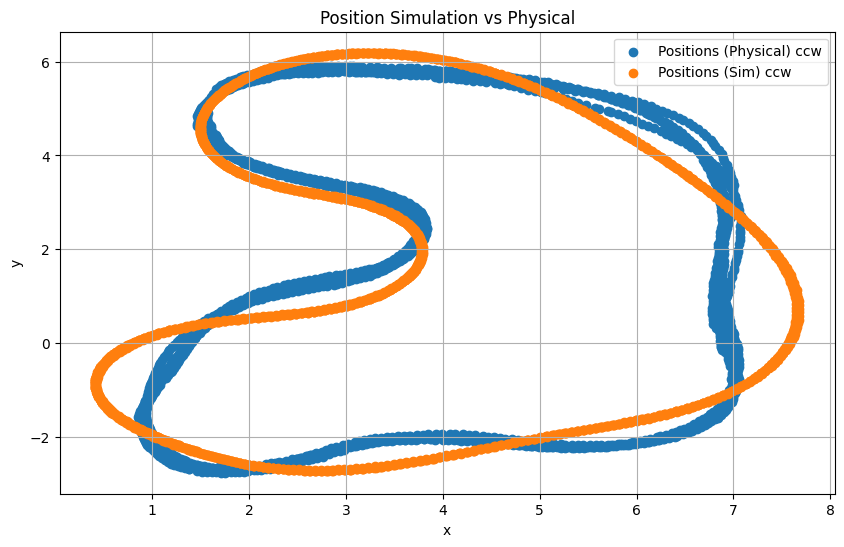

In [3]:
state_data_df = pd.read_csv(position_data_csv)

# print(state_data_df.head())
start_time = 11
end_time = 16

start_time_sim = 11.5
end_time_sim = 16.5

# Convert the 'Time' column to datetime format
start_time_bag = state_data_df['Time'].iloc[0]
state_data_df['Time'] = (state_data_df['Time'] - start_time_bag)  # Convert nanoseconds to seconds
filtered_state_data_df = state_data_df[(state_data_df['Time'] >= start_time) & (state_data_df['Time'] <= end_time)]


# Simulation Data
notebook_dir = os.getcwd()

# NNI PP (actual control)

simulation_data_df = pd.read_csv(os.path.join(notebook_dir,'sim_data.csv'), comment='#')

# print(simulation_data_df.head())
simulation_data_df = simulation_data_df[(simulation_data_df['time'] >= start_time_sim) & (simulation_data_df['time'] <= end_time_sim)]


plt.figure(figsize=(10, 6))
plt.scatter(filtered_state_data_df['s_x'], filtered_state_data_df['s_y'], label='Positions (Physical) ccw')
plt.scatter(simulation_data_df['pose_x'], simulation_data_df['pose_y'], label='Positions (Sim) ccw')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Position Simulation vs Physical')
plt.legend()
plt.grid(True)
plt.show()


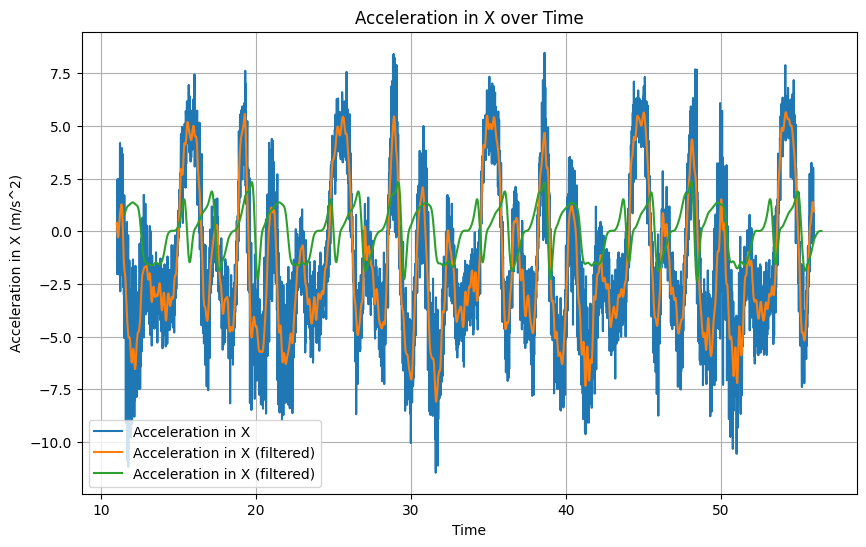

In [4]:
from scipy.signal import butter, filtfilt

# Load the CSV file if desired, or convert to DataFrame for analysis
imu_data_csv = 'IPZ10_PP_0.65/imu-data.csv'
imu_data_df = pd.read_csv(imu_data_csv)

# print(imu_data_df)

# Convert the 'Time' column to datetime format
start_time_bag = imu_data_df['Time'].iloc[0]
imu_data_df['Time'] = (imu_data_df['Time'] - start_time_bag)   # Convert nanoseconds to seconds
imu_data_df = imu_data_df[(imu_data_df['Time'] >= start_time) & (imu_data_df['Time'] <= end_time)]

# Lowpass filter
# Function to apply a low-pass Butterworth filter
def lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
# Apply the low-pass filter to the acceleration in x
cutoff_frequency = 5.0  # Cutoff frequency in Hz
sampling_rate = 100.0  # Sampling rate in Hz (adjust based on your data)
imu_data_df['linear_acceleration.x_filtered'] = lowpass_filter(
    imu_data_df['linear_acceleration.x'], cutoff_frequency, sampling_rate)



# Simulation data
simulation_data_df = pd.read_csv(os.path.join(notebook_dir,'sim_data.csv'), comment='#')
simulation_data_df = simulation_data_df[(simulation_data_df['time'] >= start_time_sim) & (simulation_data_df['time'] <= end_time_sim)]
simulation_data_df['imu_dd_x'] = lowpass_filter(
    simulation_data_df['imu_dd_x'], cutoff_frequency, sampling_rate)


# Plot acceleration in x over time
plt.figure(figsize=(10, 6))
plt.plot(imu_data_df['Time'], imu_data_df['linear_acceleration.x'], label='Acceleration in X')
plt.plot(imu_data_df['Time'], imu_data_df['linear_acceleration.x_filtered'], label='Acceleration in X (filtered)')
plt.plot(simulation_data_df['time'], simulation_data_df['imu_dd_x'], label='Acceleration in X (filtered)')
plt.xlabel('Time')
plt.ylabel('Acceleration in X (m/s^2)')
plt.title('Acceleration in X over Time')
plt.legend()
plt.grid(True)
plt.show()
